<a href="https://colab.research.google.com/github/fdluiuc/lecture-notebooks/blob/master/00c-pytorch-pretrained-resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

In this notebook, we explore briefly the pretrained network options with PyTorch.

## Problem Statement

We have an image that contains a single object. We would like to know what is in the image. 

Let's download an image from online of a golden retriever

In [ ]:
from PIL import Image
import requests

url = "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/05161950/Golden-Retriever-Slide-11.jpg"
img = Image.open(requests.get(url, stream=True).raw)

Once the image is read into Python, we have: 

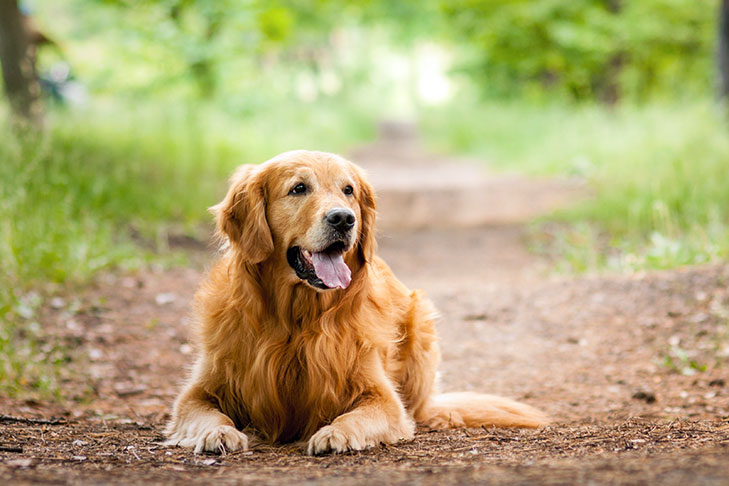

In [ ]:
img

## Pre-trained Models

Now, we could either go and collect a lot of data and train our own network. Or, we could borrow a pre-trained network and create a few predictions! 

In the interest of time, I vote we use a pre-trained network.

In [ ]:
from torchvision import models

PyTorch has many pre-trained models that are being added continuously. For the latest and greatest models, please see [PyTorch's Hub](https://pytorch.org/hub/). Alternatively, we can view a list of models by looking at the directory of the models object.

In [ ]:
dir(models)[:12]

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet']

## ResNet 101

Let's explore a ResNet architecture with 101 layers

In [ ]:
resnet = models.resnet101(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Now, we can see the layer overview by typing `resnet`. (Warning, it's long.)

In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

All pre-trained models must receive data inputted in a similar shape when compared to how the network was trained. In the case of the ResNet example, we need to make sure to allow for mini-batches of 3-channel Red-Gree-Blue (RGB) images of shape `(3 x H x W)`, where `H` and `W` must be at least 224 pixels. From there, the image will be normalized into a range of `[0, 1]`.

In [ ]:
from torchvision import transforms

# Create a pre-processing recipe
preprocess = transforms.Compose(
  [
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
    )
  ]
)

# Apply pre-processing recipe
input_img_preprocessed = preprocess(img)

As the model was trained using more than one image, we have to give the illusion we are requesting labels for more than one image. For the illusion to work, we'll extend the image dimension by 1 to create the desired a mini-batch style.

In [ ]:
import torch

input_img_under_batch = torch.unsqueeze(input_img_preprocessed, 0)

From there, we'll feed the image into the pre-trained network under an "evaluation" mode.

In [ ]:
with torch.no_grad():
    output = resnet(input_img_under_batch)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


The output does not give probabilities. Instead, the model returns unnormalized scores. We can convert the unnormalized scores to probabilities by using the softmax function.

In [ ]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities[:10])

tensor([0.0003, 0.0005, 0.0004, 0.0003, 0.0003, 0.0006, 0.0004, 0.0013, 0.0011,
        0.0004])


## Checking Classification

ResNet 101 was trained on the [ImageNet]() data set. This data set has 1,000 different labels. To predict the correct class, we'll need to download this information.

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2021-08-24 17:46:19--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2021-08-24 17:46:19 (99.2 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



Once the labels are downloaded, we can quickly read them in and figure out what object was in the photo. 

In [ ]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
print("Label - Probability")
for i in range(top5_prob.size(0)):
  print(f"{categories[top5_catid[i]]}: {top5_prob[i].item()}")


Label - Probability
bucket: 0.006022423040121794
tennis ball: 0.005594320595264435
cowboy hat: 0.004470105282962322
plunger: 0.004428583197295666
pole: 0.004371752962470055


## Classification for the Public

A lot of what we did above is arguably too "messy" for public consumption. Simply put, the interface requires a lot of additional overhead. 

[Gradio](https://gradio.app/) solves the problem of lowering the barrier of entry by providing pre-made web interfaces into models. We'll need to install the `gradio` package with `pip`.

In [15]:
%%capture
!pip install gradio

From there, we can quickly wrap the above steps into a single function and expose the function to world-wide web.

In [21]:
import gradio as gr
import numpy as np

def classify_object_resnet(numpy_image):

  img = Image.fromarray(np.uint8(numpy_image)).convert('RGB')

  input_img_preprocessed = preprocess(img)
  input_img_under_batch = torch.unsqueeze(input_img_preprocessed, 0)
  with torch.no_grad():
    output = resnet(input_img_under_batch)
  probabilities = torch.nn.functional.softmax(output[0], dim=0)

  # Show top categories per image
  top5_prob, top5_catid = torch.topk(probabilities, 5)

  my_dictionary = {}
  print("Label - Probability")
  for i in range(top5_prob.size(0)):
    print(f"{categories[top5_catid[i]]}: {top5_prob[i].item()}")
    
  return {categories[top5_catid[i]]: top5_prob[i].item() for i in range(top5_prob.size(0))}  


webcam = gr.inputs.Image(shape=(224, 224), source="webcam")
gr.Interface(fn=classify_object_resnet, inputs=webcam, outputs="label").launch(debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Your interface requires microphone or webcam permissions - this may cause issues in Colab. Use the External URL in case of issues.
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://16857.gradio.app
Interface loading below...


Label - Probability
bucket: 0.007193600293248892
hook: 0.005763933528214693
ladle: 0.005494407378137112
water bottle: 0.0052223894745111465
water jug: 0.004807920660823584


KeyboardInterrupt: ignored